### Qcodes example notebook for Alazar card ATS9360 and acq controllers

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
from qdev_wrappers.alazar_controllers.ATSChannelController import ATSChannelController
from qdev_wrappers.alazar_controllers.alazar_channel import AlazarChannel
#import qcodes.instrument_drivers.AlazarTech.acq_helpers as helpers
from qcodes.station import Station
import logging
logging.basicConfig(level=logging.INFO)
from qcodes.utils.dataset.doNd import do0d
import os
from qcodes import initialise_or_create_database_at, \
    load_or_create_experiment, Measurement, Parameter, \
    Station
import tempfile
from qcodes.instrument.parameter import ManualParameter

In [3]:
db_path = os.path.join(tempfile.gettempdir(),
                       'data_access_example.db')
initialise_or_create_database_at(db_path)

experiment = load_or_create_experiment(
    experiment_name='alazar',
    sample_name='alazar-sample')

NB: See ATS9360 example notebook for general commands 

In [4]:
# Create the ATS9360 instrument
alazar = ATSdriver.AlazarTech_ATS9360(name='Alazar')
# Print all information about this Alazar card
alazar.get_idn()

{'firmware': '21.09',
 'model': 'ATS9360',
 'max_samples': 4294967294,
 'bits_per_sample': 12,
 'serial': '970396',
 'vendor': 'AlazarTech',
 'CPLD_version': '25.16',
 'driver_version': '6.5.1',
 'SDK_version': '6.5.1',
 'latest_cal_date': '25-01-17',
 'memory_size': '4294967294',
 'asopc_type': 1763017568,
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8'}

The Alazar driver does not directly set setting one the card but requires you to call 
sync_settings_to_card to do that. Here we use the syncing context manager to ensure that 
that method is automatically called when we are done setting the settings

In [5]:
# Configure all settings in the Alazar card
with alazar.syncing():    
    alazar.clock_source('INTERNAL_CLOCK')
    alazar.sample_rate(1_000_000_000)
    alazar.clock_edge('CLOCK_EDGE_RISING')
    alazar.decimation(1)
    alazar.coupling1('DC')
    alazar.coupling2('DC')
    alazar.channel_range1(.4)
    alazar.channel_range2(.4)
    alazar.impedance1(50)
    alazar.impedance2(50)
    alazar.trigger_operation('TRIG_ENGINE_OP_J')
    alazar.trigger_engine1('TRIG_ENGINE_J')
    alazar.trigger_source1('EXTERNAL')
    alazar.trigger_slope1('TRIG_SLOPE_POSITIVE')
    alazar.trigger_level1(160)
    alazar.trigger_engine2('TRIG_ENGINE_K')
    alazar.trigger_source2('DISABLE')
    alazar.trigger_slope2('TRIG_SLOPE_POSITIVE')
    alazar.trigger_level2(128)
    alazar.external_trigger_coupling('DC')
    alazar.external_trigger_range('ETR_2V5')
    alazar.trigger_delay(0)
    alazar.timeout_ticks(0)
    alazar.aux_io_mode('AUX_IN_AUXILIARY') # AUX_IN_TRIGGER_ENABLE for seq mode on
    alazar.aux_io_param('NONE') # TRIG_SLOPE_POSITIVE for seq mode on
             

## Example 1

Pulls the raw data the alazar acquires averaged over records and buffers.

In [6]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to. Explicitly pass the default options to the Alazar.
# Dont integrate over samples but avarage over records
myctrl = ATSChannelController(name='my_controller', alazar_name='Alazar')

Put the Alazar and the controller in a station so we ensure that all parameters are captured

In [7]:
station = qc.Station(alazar, myctrl)

This controller is designed to be highlevel and it is not possible to directly set number of records, buffers and samples. The number of samples is indirecly controlled by the integration time and integration delay and the number of averages controls the number of buffers and records acquired

In [8]:
myctrl.int_delay(2e-7)
myctrl.int_time(2e-7)
print(myctrl.samples_per_record())
#myctrl.num_avg(1000)

INFO:qdev_wrappers.alazar_controllers.ATSChannelController:need 200.0 samples round up to 256
INFO:qdev_wrappers.alazar_controllers.ATSChannelController:need 400.0 samples round up to 512


512


Per default the controller does not have any channels assiated with it.

In [9]:
myctrl.channels

ChannelList(<ATSChannelController: my_controller>, AlazarChannel, [])

# 1D samples trace

Lets define a channel were we avarege over buffers and records but not over samples. This will give us a time series with a x axis defined by int_time, int_delay and the sampling rate. First we create a channel and set the relevant parameters. We may choose to append the channel to the controllers build in list of channels for future reference.

In [10]:
chan1 = AlazarChannel(myctrl, 'mychan', demod=False, integrate_samples=False)
myctrl.channels.append(chan1)

INFO:qcodes.dataset.measurements:Registered my_controller_mychan_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 313 to 1597745331.8829396
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010afe86. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}


Starting experimental run with id: 313. 


INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010afe86. 


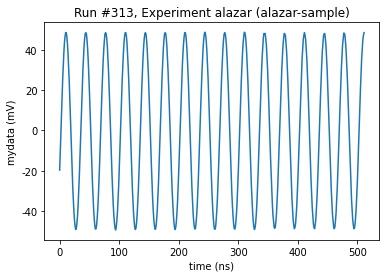

In [11]:
chan1.num_averages(1000)

chan1.alazar_channel('A')
chan1.prepare_channel()

# Measure this 
data1 = do0d(chan1.data)

We can measure the time taken to do a measurement

INFO:qcodes.dataset.measurements:Registered my_controller_mychan_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 314 to 1597745332.838112
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b0240. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b0240. 


Starting experimental run with id: 314. 
Wall time: 737 ms


(results #314@C:\Users\Farzad\AppData\Local\Temp\data_access_example.db
 ----------------------------------------------------------------------
 my_controller_mychan_time - array
 my_controller_mychan_data - array,
 [<AxesSubplot:title={'center':'Run #314, Experiment alazar (alazar-sample)'}, xlabel='time (ns)', ylabel='mydata (mV)'>],
 [None])

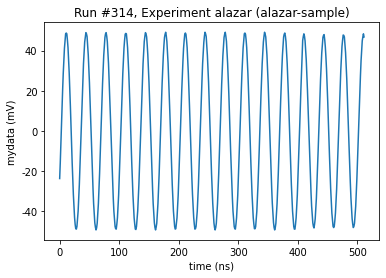

In [12]:
%%time
do0d(chan1.data)

## Demodulation

We may optionally chose to demodulate the data that we acquire using a software demodulator

In [13]:
chan1d = AlazarChannel(myctrl, 'mychan_demod_1', demod=True, integrate_samples=False)
myctrl.channels.append(chan1d)

INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 315 to 1597745333.762048
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b05cd. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b05cd. 


Starting experimental run with id: 315. 


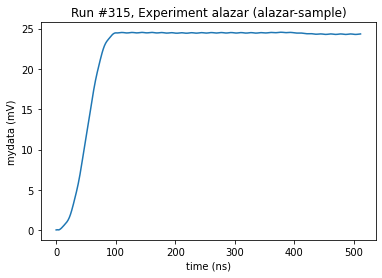

In [14]:
chan1d.num_averages(1000)

chan1d.alazar_channel('A')
chan1d.demod_freq(30e6)
chan1d.demod_type('magnitude')

chan1d.prepare_channel()

# Measure this 
data1d = do0d(chan1d.data)

We can also get the phase

INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 316 to 1597745334.7266366
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b0937. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b0937. 


Starting experimental run with id: 316. 


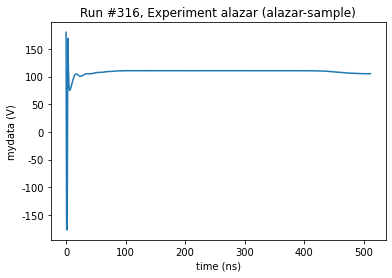

In [15]:
chan1d.demod_type('phase')

chan1d.prepare_channel()

# Measure this 
data1d = do0d(chan1d.data)

Or real part

INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 317 to 1597745335.5506203
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b0cdc. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b0cdc. 


Starting experimental run with id: 317. 


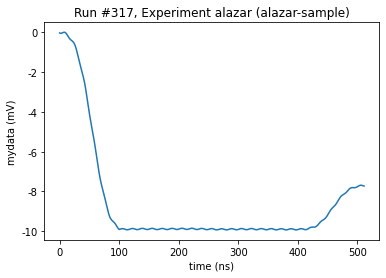

In [16]:
chan1d.demod_type('real')

chan1d.prepare_channel()

# Measure this 
data1d = do0d(chan1d.data)

Or complex part

INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 318 to 1597745336.4355154
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b1043. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b1043. 


Starting experimental run with id: 318. 


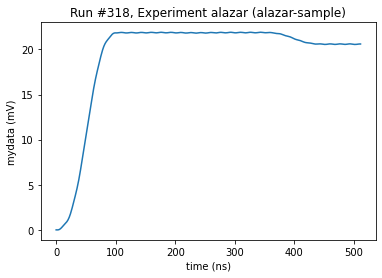

In [17]:
chan1d.demod_type('imag')

chan1d.prepare_channel()

# Measure this 
data1d = do0d(chan1d.data)

We are free to add more demodulators with different frequencies

In [18]:
chan1d2 = AlazarChannel(myctrl, 'mychan_demod_2', demod=True, integrate_samples=False)
myctrl.channels.append(chan1d2)

INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_2_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_2_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 319 to 1597745337.3395717
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b13d1. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b13d1. 


Starting experimental run with id: 319. 


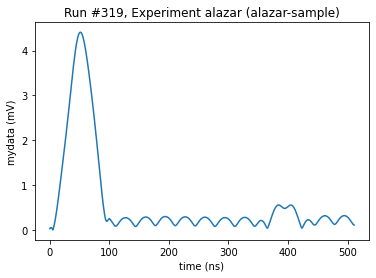

In [19]:
chan1d2.num_averages(1000)

chan1d2.alazar_channel('A')
chan1d2.demod_freq(2e6)
chan1d2.demod_type('magnitude')

chan1d2.prepare_channel()

# Measure this 
data1d = do0d(chan1d2.data)

In [20]:
myctrl.channels

ChannelList(<ATSChannelController: my_controller>, AlazarChannel, [<AlazarChannel: my_controller_mychan of ATSChannelController: my_controller>, <AlazarChannel: my_controller_mychan_demod_1 of ATSChannelController: my_controller>, <AlazarChannel: my_controller_mychan_demod_2 of ATSChannelController: my_controller>])

We can get the data from multiple chanels in one provided that the shape (buffers,records,samples) is the same. The time overhead is fairly small as we are only capturing the data once.

INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_data in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_data in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_2_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 320 to 1597745338.2161965
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b1730. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qc

Starting experimental run with id: 320. 
Wall time: 1.8 s


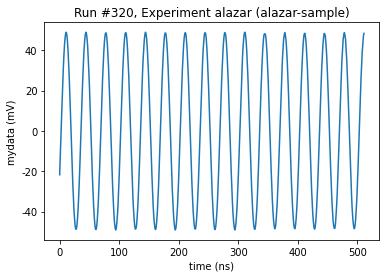

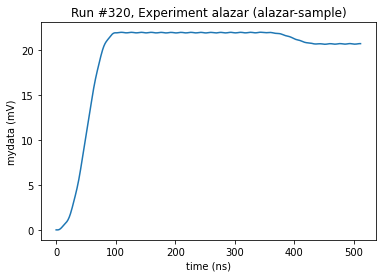

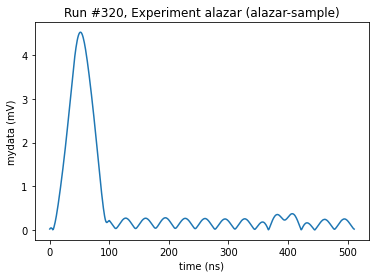

In [21]:
%%time
data = do0d(myctrl.channels.data)

INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_data in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_data in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_2_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 321 to 1597745340.477466
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b1fe8. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qco

Starting experimental run with id: 321. 


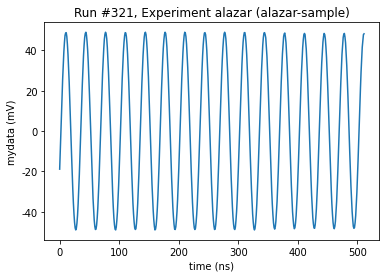

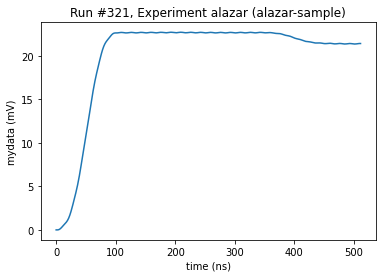

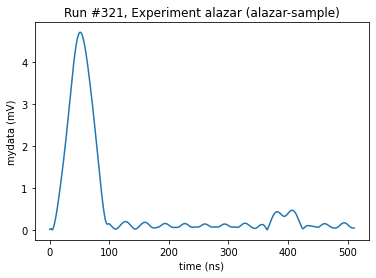

In [22]:
data1 = do0d(myctrl.channels.data)

# 1D records trace

We can also do a 1D trace of records

In [23]:
chan2 = AlazarChannel(myctrl, 'myrecchan', demod=False, average_records=False)
myctrl.channels.append(chan2)

INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 322 to 1597745342.6931672
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b28b7. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 55, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b28b7. 


Starting experimental run with id: 322. 


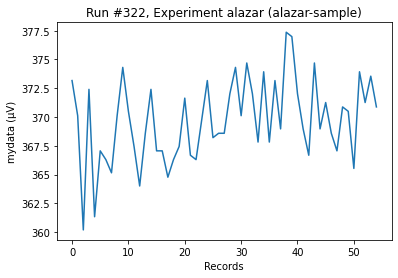

In [24]:
chan2.num_averages(100)
chan2.records_per_buffer(55)
chan2.alazar_channel('A')

chan2.prepare_channel()

# Measure this 
data2 = do0d(myctrl.channels[-1].data)

Again it is posssible to demodulate the data

In [25]:
chan2d = AlazarChannel(myctrl, 'myrecchan_D', demod=True, average_records=False)
myctrl.channels.append(chan2d)

In [26]:
print(myctrl.int_delay())
print(myctrl.int_time())

2e-07
2e-07


In [27]:
myctrl.int_time.cache.get()

2e-07

In [28]:
chan2d.alazar_channel('A')
chan2d.demod_freq(1e6)
chan2d.demod_type('magnitude')

INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_D_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_D_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 323 to 1597745343.7817738
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b2cfc. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 55, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}


Starting experimental run with id: 323. 


INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b2cfc. 


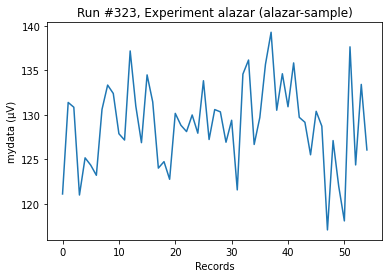

In [29]:
chan2d.num_averages(100)
chan2d.records_per_buffer(55)
chan2d.alazar_channel('A')

chan2d.prepare_channel()

# Measure this 
data2d = do0d(myctrl.channels[-1].data)

In [30]:
myctrl.channels

ChannelList(<ATSChannelController: my_controller>, AlazarChannel, [<AlazarChannel: my_controller_mychan of ATSChannelController: my_controller>, <AlazarChannel: my_controller_mychan_demod_1 of ATSChannelController: my_controller>, <AlazarChannel: my_controller_mychan_demod_2 of ATSChannelController: my_controller>, <AlazarChannel: my_controller_myrecchan of ATSChannelController: my_controller>, <AlazarChannel: my_controller_myrecchan_D of ATSChannelController: my_controller>])

In [31]:
myctrl.channels[-2:]

ChannelList(<ATSChannelController: my_controller>, AlazarChannel, (<AlazarChannel: my_controller_myrecchan of ATSChannelController: my_controller>, <AlazarChannel: my_controller_myrecchan_D of ATSChannelController: my_controller>))

INFO:qcodes.dataset.measurements:Registered my_controller_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_data in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_D_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 324 to 1597745344.7232428
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b30a7. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 55, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b30a7. 


Starting experimental run with id: 324. 


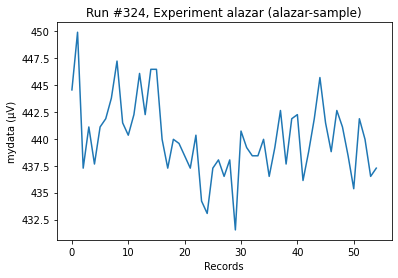

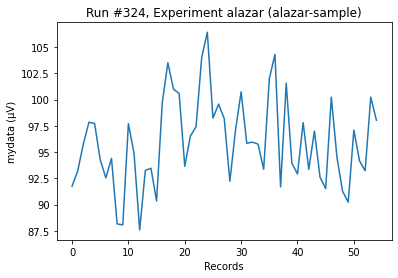

In [32]:
data = do0d(myctrl.channels[-2:].data)

# 1D Buffer trace

We can also do a 1D trace over buffers in the same way

In [33]:
chan3 = AlazarChannel(myctrl, 'myrecchan', demod=False, average_buffers=False)
myctrl.channels.append(chan3)


Since we are capturing a lot of buffers it may be needed to increase the timeout

INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_buffers in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 325 to 1597745346.436814
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b3749. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b3749. 


Starting experimental run with id: 325. 
10000


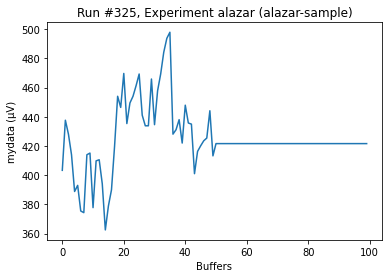

In [34]:
chan3.num_averages(100)
chan3.buffers_per_acquisition(100)
chan3.alazar_channel('A')
alazar.buffer_timeout.set(10000)
chan3.prepare_channel()

# Measure this 
data3 = do0d(chan3.data)
print(alazar.buffer_timeout())

And demodulate this

In [35]:
chan3d = AlazarChannel(myctrl, 'myrecchan_d', demod=True, average_buffers=False)
myctrl.channels.append(chan3d)

INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_d_buffers in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_d_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 326 to 1597745347.4206314
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b3b2d. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b3b2d. 


Starting experimental run with id: 326. 
10000


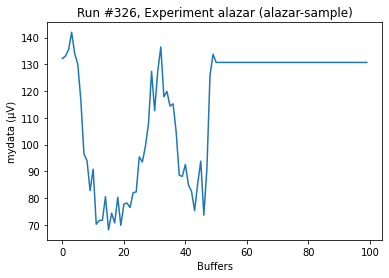

In [36]:
chan3d.num_averages(100)
chan3d.buffers_per_acquisition(100)
chan3d.alazar_channel('A')
chan3d.demod_freq(2e6)
chan3d.demod_type('magnitude')
alazar.buffer_timeout.set(10000)
chan3d.prepare_channel()

# Measure this 
data3 = do0d(chan3d.data)
print(alazar.buffer_timeout())

INFO:qcodes.dataset.measurements:Registered my_controller_buffers in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_buffers in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_data in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_d_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 327 to 1597745348.3310325
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b3ec2. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b3ec2. 


Starting experimental run with id: 327. 


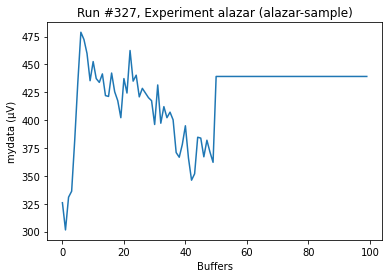

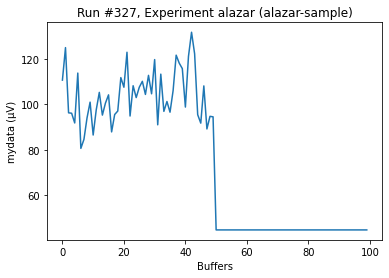

In [37]:
data = do0d(myctrl.channels[-2:].data)

# 2D Samples vs records

In [38]:
chan4 = AlazarChannel(myctrl, 'myrecvssamples', demod=False, average_records=False, integrate_samples=False)
myctrl.channels.append(chan4)

INFO:qcodes.dataset.measurements:Registered my_controller_myrecvssamples_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecvssamples_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecvssamples_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 328 to 1597745349.9531183
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b450b. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 100, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b450b. 


Starting experimental run with id: 328. 


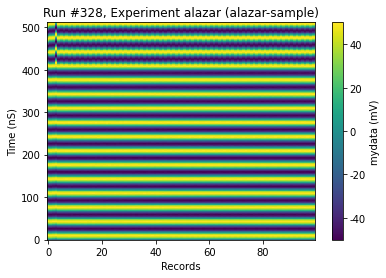

In [39]:
chan4.num_averages(1)
chan4.records_per_buffer(100)
chan4.alazar_channel('A')
chan4.prepare_channel()
# Measure this 
data4 = do0d(chan4.data)

# 2D Buffers vs Records

INFO:qcodes.dataset.measurements:Registered my_controller_mybuffersvsrecs_buffers in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mybuffersvsrecs_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mybuffersvsrecs_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 329 to 1597745351.2229292
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b4a04. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 72, 'buffers_per_acquisition': 10, 'allocated_buffers': 4}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b4a04. 


Starting experimental run with id: 329. 
10000


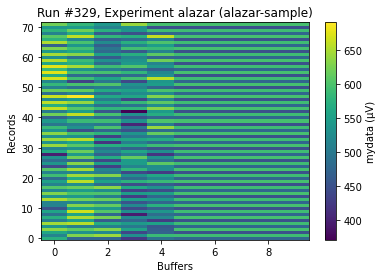

In [40]:
chan5 = AlazarChannel(myctrl, 'mybuffersvsrecs', demod=False, average_records=False, average_buffers=False)
alazar.buffer_timeout.set(10000)
chan5.records_per_buffer(72)
chan5.buffers_per_acquisition(10)
chan5.num_averages(1)
chan5.alazar_channel('A')
chan5.prepare_channel()
# Measure this
data5 = do0d(chan5.data)
print(alazar.buffer_timeout())

# 2D Buffers vs Samples

INFO:qcodes.dataset.measurements:Registered my_controller_mybufvssamples_buffers in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mybufvssamples_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mybufvssamples_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 330 to 1597745352.393276
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b4e94. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}


Starting experimental run with id: 330. 


INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b4e94. 


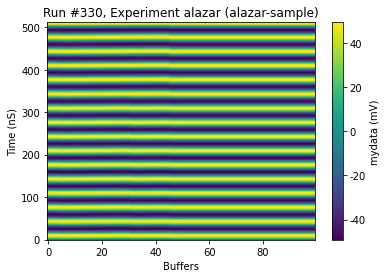

In [41]:
chan6 = AlazarChannel(myctrl, 'mybufvssamples', demod=False, average_buffers=False, integrate_samples=False)
chan6.buffers_per_acquisition(100)
chan6.num_averages(100)
chan6.alazar_channel('A')
chan6.prepare_channel()
# Measure this 
data6 = do0d(chan6.data)


# Single point

In [42]:
chan7 = AlazarChannel(myctrl, 'mybufvssamples', demod=False)


chan7.num_averages(100)
chan7.alazar_channel('A')
chan7.prepare_channel()
# Measure this

data7 = do0d(chan7.data, do_plot=False)

INFO:qcodes.dataset.measurements:Registered my_controller_mybufvssamples_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 331 to 1597745353.8072171
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b541c. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 100, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b541c. 


Starting experimental run with id: 331. 


As we are not integrating over samples the setpoints (label, unit and ticks on number) are automatically set from the integration time and integration delay. **Note at the moment this does not cut of the int_delay from the plot. It probably should**

# Multiple channels

In [43]:
chan1 = AlazarChannel(myctrl, 'mychan1', demod=False, integrate_samples=False)
chan1.num_averages(1000)
chan1.alazar_channel('A')
chan1.prepare_channel()
chan2 = AlazarChannel(myctrl, 'mychan2', demod=False, integrate_samples=False)
chan2.num_averages(1000)
chan2.alazar_channel('B')
chan2.prepare_channel()
myctrl.channels.append(chan1)
myctrl.channels.append(chan2)


#plot = qc.MatPlot(data6.my_controller_mybufvssamples_data)

INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan1_data in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan2_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 332 to 1597745354.0227413
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174010b54f3. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 512, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174010b54f3. 


Starting experimental run with id: 332. 


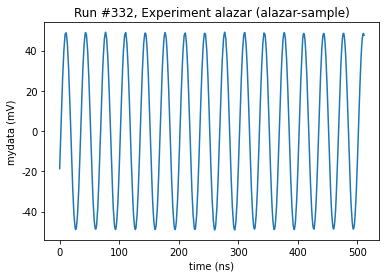

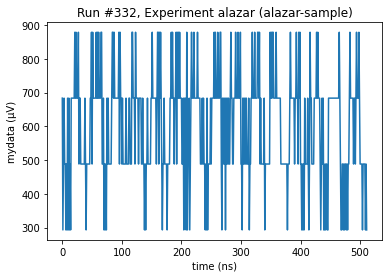

In [44]:
data7 = do0d(myctrl.channels[-2:].data)